In [131]:
import copy
import sys

import control as ct
# import sympy
# from sympy.plotting import plot
import sympy as sp
import numpy as np
# import penbegone as pbg
from penbegone import common as bgcom
# from penbegone import plotting as bgplot
# from penbegone.common import printeq

sys.path.append("..")

import plant as p
import controller as c

values = {}  # The dictionary holding values for the symbolic variables.

%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create a simplified longitudinal model.

In [132]:
nllm = p.build_longitudinal_nonlinear_model()

variables = [p.pitch, p.throttle, p.v, p.h]
throttle_0 = sp.symbols("throttle_0")
v_0 = sp.symbols("v_0")
h_0 = sp.symbols("h_0")
trim = [p.theta_0, throttle_0, v_0, h_0]
states = [p.v, p.h]
derivatives = [p.v_dot, p.h_dot]

nllm.show()

[1]: $v_{dot}$ = $\frac{- 0.5 C_{drag} S \rho v^{2} + F_{t} \delta_{t} - g \sin{\left(\theta \right)}}{m}$

[2]: $h_{dot}$ = $v \sin{\left(\theta - \theta_{0} \right)}$

Linearize the model.

In [133]:
llm = bgcom.Equations()
for x, f in zip(derivatives, nllm):
    f = f+x  # Do not include the derivative in the linearization.
    llm.add(x, bgcom.linearize(f, variables, trim))

llm.show()

[1]: $v_{dot}$ = $- \frac{1.0 C_{drag} S \rho v_{0} \left(v - v_{0}\right)}{m} + \frac{F_{t} \left(\delta_{t} - throttle_{0}\right)}{m} - \frac{g \left(\theta - \theta_{0}\right) \cos{\left(\theta_{0} \right)}}{m} + \frac{- 0.5 C_{drag} S \rho v_{0}^{2} + F_{t} throttle_{0} - g \sin{\left(\theta_{0} \right)}}{m}$

[2]: $h_{dot}$ = $v_{0} \left(\theta - \theta_{0}\right)$

Trim around zero.

In [134]:
values[p.theta_0] = 0
values[throttle_0] = 0
values[v_0] = 20
values[h_0] = 0

llm.subs(values)
llm.show(show_all=True)

[1]: $v_{dot}$ = $- \frac{20.0 C_{drag} S \rho \left(v - 20.0\right)}{m} - \frac{200.0 C_{drag} S \rho}{m} + \frac{F_{t} \delta_{t}}{m} - \frac{g \theta}{m}$

[2]: $h_{dot}$ = $20.0 \theta$

Assign values to calculate the pole-zero plot.

In [135]:
values[p.rho] = 1.225
values[p.m] = 10
values[p.S] = 1
values[p.c_drag] = 0.2
values[p.F_t] = 30
values[p.g] = 9.81
llm.subs(values)
llm.show(show_all=True)

[1]: $v_{dot}$ = $3.0 \delta_{t} - 0.981 \theta - 0.49 v + 4.9$

[2]: $h_{dot}$ = $20.0 \theta$

[-0.49+0.j  0.  +0.j]
[]


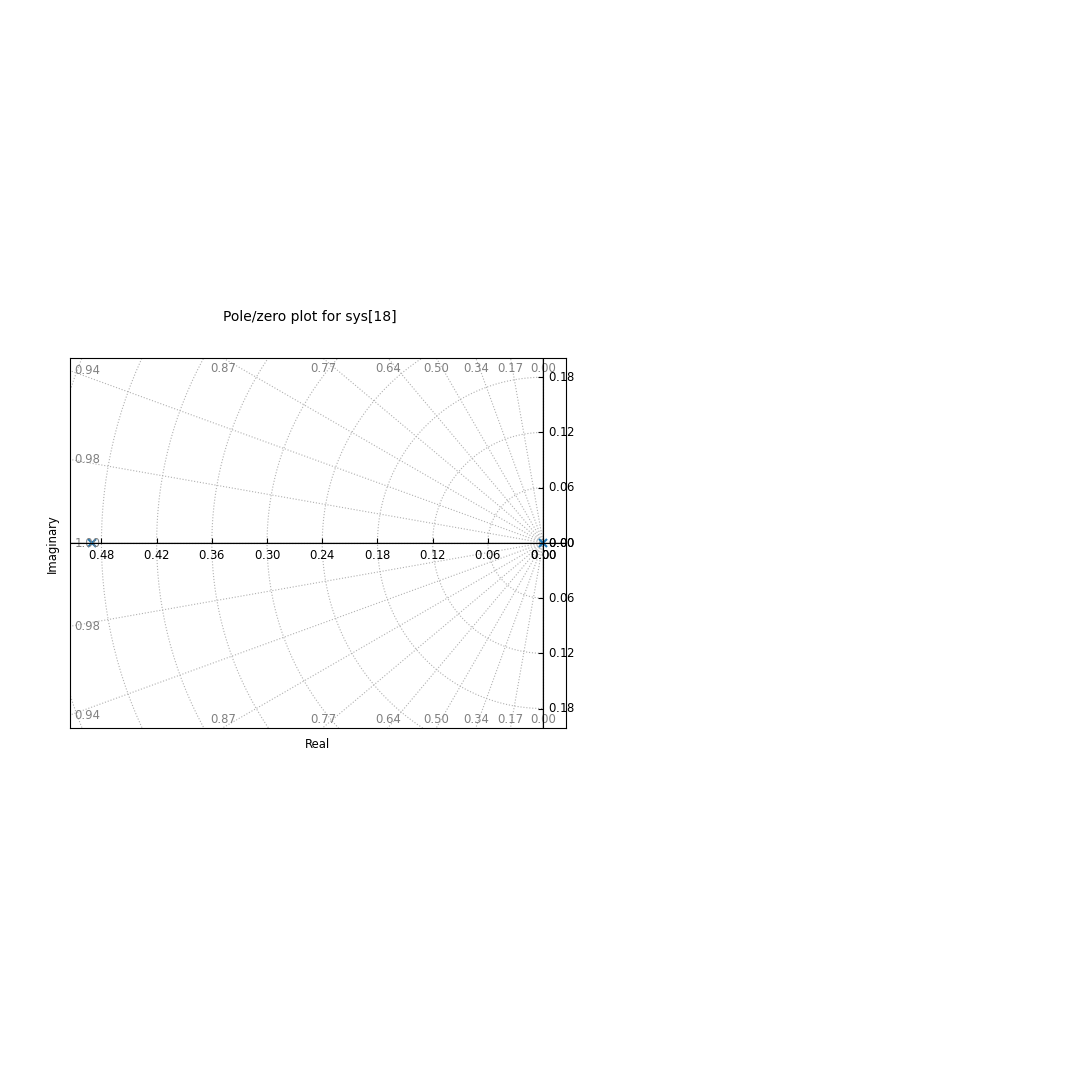

In [136]:
states_ol = [p.v, p.h]  # Already declared.
inputs_ol = [p.pitch, p.throttle]

# A = np.zeros((2,2))
# A[0][0] = llm.rht[1].coeff(states_ol[0])
# A[1][1] = llm.rht[2].coeff(states_ol[1])

# B = np.zeros((2,2))
# B[0][0] = llm.rht[1].coeff(inputs_ol[0])
# B[1][0] = llm.rht[2].coeff(inputs_ol[1])

# C = np.ones((1,2))
# D = np.zeros((1,1))

dimA = len(states_ol)
A = np.zeros((dimA,dimA))
for idx in range(dimA):
    for idy in range(dimA):
        A[idx][idy] = llm.rht[idx+1].coeff(states_ol[idy])

dimB = len(inputs_ol)
B = np.zeros((dimA,dimB))
for idx in range(dimA):
    for idy in range(dimB):
        B[idx][idy] = llm.rht[idx+1].coeff(inputs_ol[idy])

C = np.eye(2)
D = np.zeros((2,2))

aircraft = ct.ss(A, B, C, D)
print(aircraft.poles())
print(aircraft.zeros())
response = ct.pole_zero_plot(aircraft, grid=True)


Insert the controller to the original system.

In [137]:
tecs, tecs_states, tecs_state_der, tecs_inputs, tecs_outputs = c.tecs_full()

# Simplify with some values.
values[c.climb_max] = 5
values[c.h_dem_dot] = 0
values[c.sink_min] = 8
values[c.thr_max] = 1
values[c.thr_min] = 0
values[c.thr_trim] = 0.3
values[c.v_dem_dot] = 0
values[c.v_dem_dot] = 0
tecs.subs(values)

tecs.show()


[1]: $x_{SEB}$ = $\frac{k_{i} \left(- 9.81 h \left(2.0 - w\right) + 9.81 h_{d} \left(2.0 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w\right)}{k_{tc}}$

[2]: $x_{KE}$ = $\frac{w \left(0.5 v^{2} - 0.5 v_{d}^{2}\right)}{k_{tc}}$

[3]: $x_{THR}$ = $\frac{0.00784 k_{i} \left(- 9.81 h + 9.81 h_{d} - 0.5 v^{2} + 0.5 v_{d}^{2}\right)}{k_{tc}}$

[4]: $\delta_{t}$ = $x_{intthr} + 0.3 + \frac{0.00784 \left(- 9.81 h + 9.81 h_{d}\right)}{k_{tc}} + \frac{0.00784 \left(- 9.81 h + 9.81 h_{d} - 0.5 v^{2} + 0.5 v_{d}^{2} + \frac{k_{td} \left(- 9.81 h + 9.81 h_{d}\right)}{k_{tc}}\right)}{k_{tc}}$

[5]: $\theta$ = $\frac{0.102 \left(\frac{k_{pd} \left(- 9.81 h \left(2.0 - w\right) + 9.81 h_{d} \left(2.0 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w\right)}{k_{tc}} + x_{intKE} + x_{intsebdot} + \frac{- 9.81 h \left(2.0 - w\right) + 9.81 h_{d} \left(2.0 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w}{k_{tc}}\right)}{v}$

In [138]:
nllm_cl = copy.deepcopy(nllm)

# Add the TECS states.
for idx in range(3):
    offset = 1
    nllm_cl.add(tecs.lht[idx+offset], tecs.rht[idx+offset], display=False)

# Replace the control inputs.
for idx in range(2):
    offset = 4
    # Using subs instead of apply, since it's too taxing to simplify sin(p.theta)
    nllm_cl.subs({tecs.lht[idx+offset]: tecs.rht[idx+offset]})
    # nllm_cl.apply(tecs.lht[idx+offset],tecs.rht[idx+offset])

nllm_cl.show(show_all=True)
states_cl = states + tecs_states
derivatives_cl = derivatives + tecs_state_der
inputs_cl = tecs_inputs

[1]: $v_{dot}$ = $\frac{- 0.5 C_{drag} S \rho v^{2} + F_{t} \left(x_{intthr} + 0.3 + \frac{0.00784 \left(- 9.81 h + 9.81 h_{d}\right)}{k_{tc}} + \frac{0.00784 \left(- 9.81 h + 9.81 h_{d} - 0.5 v^{2} + 0.5 v_{d}^{2} + \frac{k_{td} \left(- 9.81 h + 9.81 h_{d}\right)}{k_{tc}}\right)}{k_{tc}}\right) - g \sin{\left(\frac{0.101936799184506 \left(\frac{k_{pd} \left(- 9.81 h \left(2 - w\right) + 9.81 h_{d} \left(2 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w\right)}{k_{tc}} + x_{intKE} + x_{intsebdot} + \frac{- 9.81 h \left(2 - w\right) + 9.81 h_{d} \left(2 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w}{k_{tc}}\right)}{v} \right)}}{m}$

[2]: $h_{dot}$ = $- v \sin{\left(\theta_{0} - \frac{0.101936799184506 \left(\frac{k_{pd} \left(- 9.81 h \left(2 - w\right) + 9.81 h_{d} \left(2 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w\right)}{k_{tc}} + x_{intKE} + x_{intsebdot} + \frac{- 9.81 h \left(2 - w\right) + 9.81 h_{d} \left(2 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w}{k_{tc}}\right)}{v} \right)}$

[3]: $x_{SEB}$ = $\frac{k_{i} \left(- 9.81 h \left(2.0 - w\right) + 9.81 h_{d} \left(2.0 - w\right) + 0.5 v^{2} w - 0.5 v_{d}^{2} w\right)}{k_{tc}}$

[4]: $x_{KE}$ = $\frac{w \left(0.5 v^{2} - 0.5 v_{d}^{2}\right)}{k_{tc}}$

[5]: $x_{THR}$ = $\frac{0.00784 k_{i} \left(- 9.81 h + 9.81 h_{d} - 0.5 v^{2} + 0.5 v_{d}^{2}\right)}{k_{tc}}$

Linearize the closed-loop model.

In [139]:
llm_cl = bgcom.Equations()
variables = states_cl + inputs_cl
trim = [v_0, h_0, 0, 0, 0, v_0, h_0]  # It's not entirely accurate for the integrators to be trimmed to 0.
for x, f in zip(derivatives_cl, nllm_cl):
    f = f+x  # Do not include the derivative in the linearization.
    llm_cl.add(x, bgcom.linearize(f, variables, trim))

Introduce values for easier interpretation.

In [140]:
values[c.k_i] = 0.3
values[c.k_pd] = 0.3
values[c.k_tc] = 5
values[c.k_td] = 0.5
values[c.w] = 1
llm_cl.subs(values)
llm_cl.show(show_all=True)

[1]: $v_{dot}$ = $- 0.0842 h + 0.0842 h_{d} - 0.61 v + 0.12 v_{d} - 0.005 x_{intKE} - 0.005 x_{intsebdot} + 3.0 x_{intthr} + 5.8$

[2]: $h_{dot}$ = $- 0.26 h + 0.26 h_{d} + 0.53 v - 0.53 v_{d} + 0.102 x_{intKE} + 0.102 x_{intsebdot}$

[3]: $x_{SEB}$ = $- 0.589 h + 0.589 h_{d} + 1.2 v - 1.2 v_{d}$

[4]: $x_{KE}$ = $4.0 v - 4.0 v_{d}$

[5]: $x_{THR}$ = $- 0.00462 h + 0.00462 h_{d} - 0.00941 v + 0.00941 v_{d}$

Make the pole-zero plot of the closed-loop system.

In [141]:
dimA = len(states_cl)
A = np.zeros((dimA,dimA))
for idx in range(dimA):
    for idy in range(dimA):
        A[idx][idy] = llm_cl.rht[idx+1].coeff(states_cl[idy])

dimB = len(inputs_cl)
B = np.zeros((dimA,dimB))
for idx in range(dimA):
    for idy in range(dimB):
        B[idx][idy] = llm_cl.rht[idx+1].coeff(inputs_cl[idy])
        #TODO: Add the constant terms as another input.

C = np.zeros((2,dimA))
C[0][0] = 1
C[1][1] = 1

D = np.zeros((2,dimB))

aircraft = ct.ss(A, B, C, D,
                 name="Closed-Loop",
                 states=["v", "h", "x_SEB", "x_KE", "x_THR"],
                 inputs=["v_dem", "h_dem"],
                 outputs=["v", "h"]
                 )
print(aircraft)


<StateSpace>: Closed-Loop
Inputs (2): ['v_dem', 'h_dem']
Outputs (2): ['v', 'h']
States (5): ['v', 'h', 'x_SEB', 'x_KE', 'x_THR']

A = [[-0.61  -0.084 -0.005 -0.005  3.   ]
     [ 0.53  -0.26   0.102  0.102  0.   ]
     [ 1.2   -0.589  0.     0.     0.   ]
     [ 4.     0.     0.     0.     0.   ]
     [-0.009 -0.005  0.     0.     0.   ]]

B = [[ 0.12   0.084]
     [-0.53   0.26 ]
     [-1.2    0.589]
     [-4.     0.   ]
     [ 0.009  0.005]]

C = [[1. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0.]]

D = [[0. 0.]
     [0. 0.]]


[-5.765e-01+0.j    -8.522e-02+0.346j -8.522e-02-0.346j -1.232e-01+0.j
  2.865e-17+0.j   ]
[-0.796+0.j -0.15 +0.j  0.   +0.j]


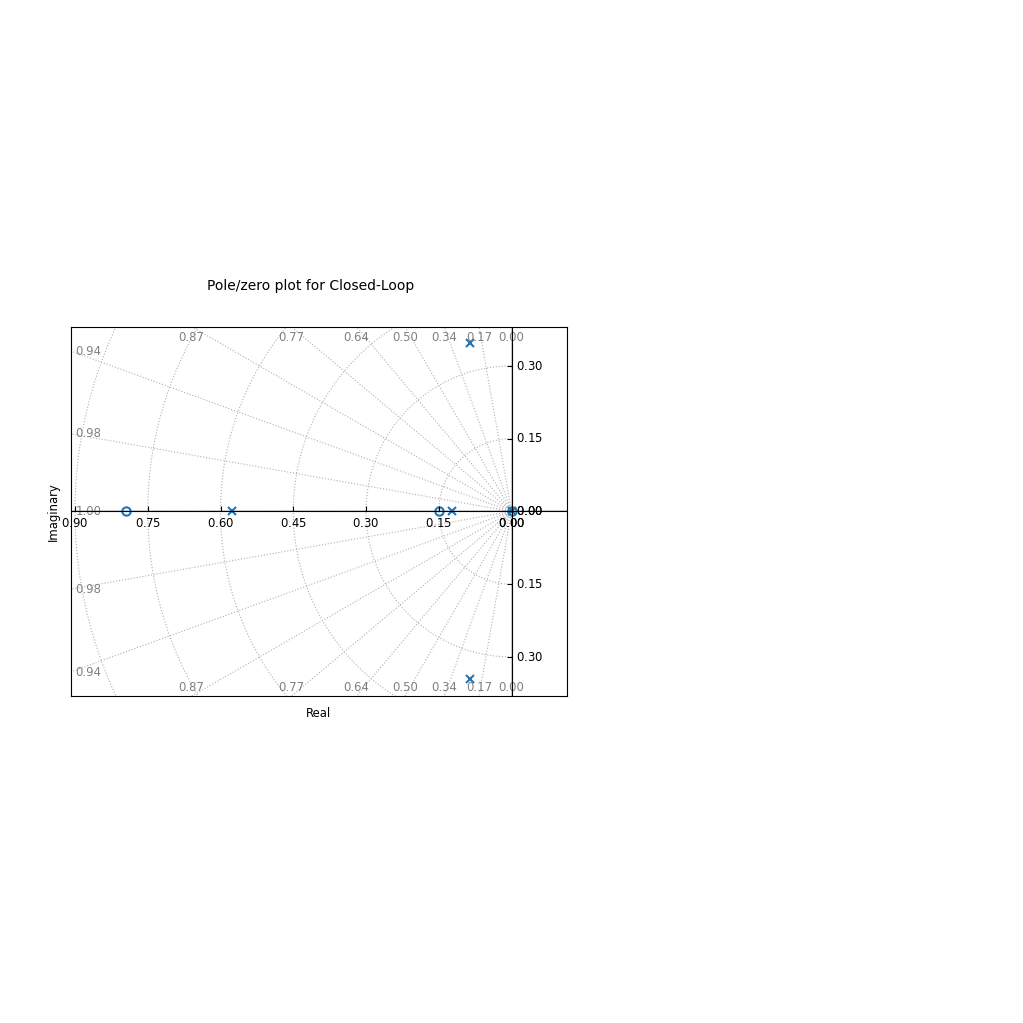

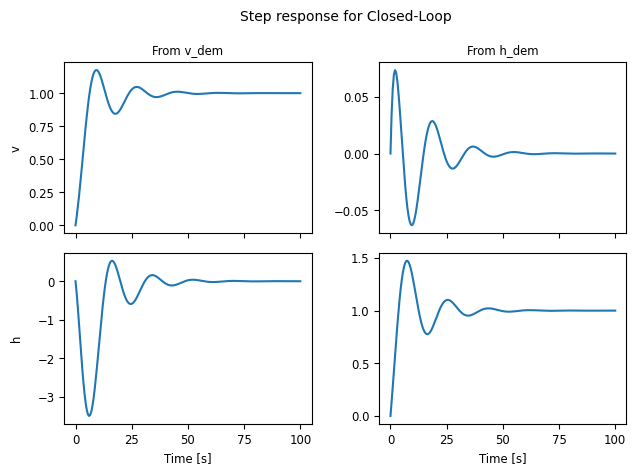

In [150]:
print(aircraft.poles())
print(aircraft.zeros())
response = ct.pole_zero_plot(aircraft, grid=True)
timepts = np.linspace(0, 100, num=200)
response = ct.step_response(aircraft, timepts=timepts)
response.plot()
